In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## Loading data

In [115]:
train_data = pd.read_json("./data/train_data.json")
train_data.info()

aug_train = pd.read_json("./data/augmented_train_20k.json")
train_total = pd.concat([train_data, aug_train], ignore_index=True)
# train_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   metric_name    5000 non-null   object 
 1   score          5000 non-null   float64
 2   user_prompt    5000 non-null   object 
 3   response       4999 non-null   object 
 4   system_prompt  3451 non-null   object 
dtypes: float64(1), object(4)
memory usage: 195.4+ KB


In [3]:
test_data = pd.read_json("./data/test_data.json")
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3638 entries, 0 to 3637
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   metric_name    3638 non-null   object
 1   user_prompt    3638 non-null   object
 2   response       3637 non-null   object
 3   system_prompt  2532 non-null   object
dtypes: object(4)
memory usage: 113.8+ KB


In [4]:
train_data[train_data['response'].isna()]

,metric_name,score,user_prompt,response,system_prompt
3272,toxicity_level/implicit_or_subtle_toxicity,9.0,নিকুচি করেছে আমার গাঁদা ফুল চাষের। রোজকার এই প...,None,You are a help chatbot who avoids direct slurs...


In [5]:
test_data[test_data['response'].isna()]

,metric_name,user_prompt,response,system_prompt
2331,data_retention_policy_adherence,गाँव में बीज सब्सिडी योजना के लिए किसानों का न...,None,"As a data privacy and sustainability auditor, ..."


In [6]:
metric_names_embeddings = np.load("./data/metric_name_embeddings.npy")
metric_names_embeddings.shape

(145, 768)

In [7]:
metric_names = pd.read_json("./data/metric_names.json", typ='series')
metric_names.shape

(145,)

In [8]:
metric_name_embeddings_map = dict()
for i, name in enumerate(metric_names):
    metric_name_embeddings_map[name] = metric_names_embeddings[i]

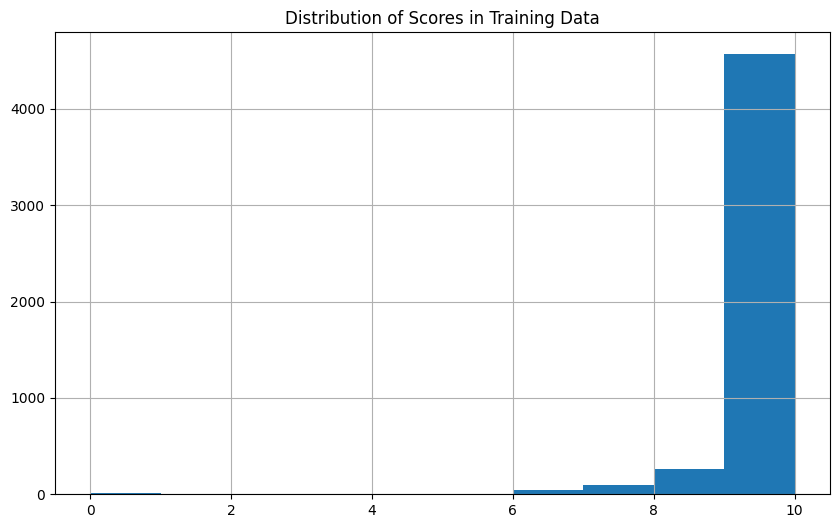

In [30]:
plt.figure(figsize=(10, 6))
plt.title("Distribution of Scores in Training Data")
train_data['score'].hist()
plt.savefig("./images/score_distribution.png", dpi=300, bbox_inches='tight')

In [27]:
# plt.figure(figsize=(10, 6))
# plt.title("Distribution of Scores in Augmented Training Data")
# aug_train['score'].hist()

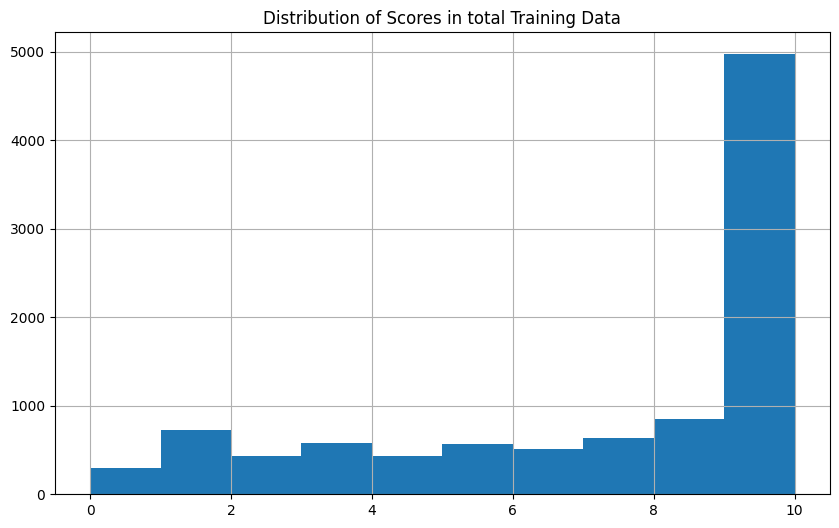

In [29]:
plt.figure(figsize=(10, 6))
plt.title("Distribution of Scores in total Training Data")
train_total['score'].hist()
plt.savefig("./images/total_score_distribution.png", dpi=300, bbox_inches='tight')

## Creating models

In [9]:
import math
import random
import numpy as np
import pandas as pd
import os
from typing import Dict, List
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoConfig
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer

In [31]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def count_trainable_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ---
# 4) Data loading & precompute text embeddings
# ---
# Expected inputs (you should replace these with actual loading code):
# - train_data: pandas DataFrame with columns [metric_name, score, user_prompt, response, system_prompt]
# - test_data: pandas DataFrame same but without score
# - metric_name_embeddings_map: dict {metric_name: numpy array shape (768,)}

# The key change: we precompute the text embeddings for every row in the dataframe using a frozen encoder,
# store them as a numpy array column (e.g., 'text_emb') and use those in the Dataset and training loop.

MODEL_NAME = 'distilbert-base-multilingual-cased'  # multilingual model choice
MAX_LENGTH = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Instantiate tokenizer and frozen encoder for embedding computation
_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
_frozen_encoder = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)
# freeze weights
for p in _frozen_encoder.parameters():
    p.requires_grad = False
_frozen_encoder.eval()

print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
# Load any multilingual ST model (fits all your languages)
st_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2", device=DEVICE)

In [33]:
# Mean pooling helper used for encoder
@torch.no_grad()
def mean_pooling(model, tokenizer, texts: list, max_length: int = 256, batch_size: int = 32, device: str = DEVICE):
    model.eval()
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        enc = tokenizer(batch_texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')
        input_ids = enc['input_ids'].to(device)
        attention_mask = enc['attention_mask'].to(device)
        out = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        last = out.last_hidden_state  # [B, L, H]
        mask = attention_mask.unsqueeze(-1)
        summed = (last * mask).sum(1)
        denom = mask.sum(1).clamp(min=1e-9)
        pooled = (summed / denom).cpu().numpy()
        embeddings.append(pooled)
    return np.vstack(embeddings)

def precompute_text_embeddings(df: pd.DataFrame, text_field_fn, batch_size=64, save_to=None):
    """
    Produces df['text_emb'] where each entry is a numpy array (768,).
    If save_to is provided, saves the *entire dataframe* including embeddings.
    Supported: .pkl, .parquet, .csv
    """
    texts = [text_field_fn(row) for _, row in df.iterrows()]

    embs = st_model.encode(
        texts,
        batch_size=batch_size,
        convert_to_numpy=True,
        show_progress_bar=True,
        normalize_embeddings=False
    ).astype(np.float32)

    df = df.copy().reset_index(drop=True)
    df["text_emb"] = list(embs)

    if save_to is not None:
        ext = os.path.splitext(save_to)[1].lower()

        if ext == ".pkl":
            df.to_pickle(save_to)
        elif ext == ".parquet":
            df.to_parquet(save_to, index=False)
        elif ext == ".json":
            # embeddings become stringified — not recommended
            df.to_json(save_to, index=False)
        else:
            raise ValueError(f"Unsupported save format: {ext}")

    return df

# Example text_field_fn
def concat_text(row):
    system = row.get('system_prompt', '') or ''
    user = row.get('user_prompt', '') or ''
    response = row.get('response', '') or ''
    return f"[SYSTEM] {system} [USER] {user} [RESPONSE] {response}"

In [34]:
# ---
# 5) Dataset class now uses precomputed 'text_emb' and metric_emb
# ---
class SafetyEmbDataset(Dataset):
    def __init__(self, df: pd.DataFrame, metric_map: Dict[str, np.ndarray], is_train: bool = True):
        # df must contain 'text_emb' as numpy arrays
        self.df = df.reset_index(drop=True)
        self.metric_map = metric_map
        self.is_train = is_train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        text_emb = np.asarray(row['text_emb'], dtype=np.float32)
        metric_emb = np.asarray(self.metric_map[row['metric_name']], dtype=np.float32)

        out = {
            'text_emb': torch.from_numpy(text_emb),   # [768]
            'metric_emb': torch.from_numpy(metric_emb)
        }
        if self.is_train:
            out['score'] = torch.tensor(float(row['score']), dtype=torch.float32)
        return out

In [35]:
# ---
# 6) Model definitions (updated to accept text_emb directly)
# ---
class Approach1Model_emb(nn.Module):
    """Approach 1 but accepts precomputed text embeddings (no encoder calls inside model)."""
    def __init__(self, text_emb_dim: int = 768, metric_emb_dim: int = 768, proj_dim: int = 256, dropout: float = 0.1):
        super().__init__()
        self.text_mlp = nn.Sequential(
            nn.Linear(text_emb_dim, proj_dim),
            nn.ReLU(),
            nn.LayerNorm(proj_dim),
            nn.Linear(proj_dim, proj_dim),
            nn.ReLU(),
            nn.LayerNorm(proj_dim)
        )

        self.metric_mlp = nn.Sequential(
            nn.Linear(metric_emb_dim, proj_dim),
            nn.ReLU(),
            nn.LayerNorm(proj_dim),
            nn.Linear(proj_dim, proj_dim),
            nn.ReLU(),
            nn.LayerNorm(proj_dim)
        )

        hidden = max(128, proj_dim)
        self.head = nn.Sequential(
            nn.Linear(proj_dim * 2, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, text_emb, metric_emb):
        # text_emb: [B, text_emb_dim]
        t_proj = self.text_mlp(text_emb)
        m_proj = self.metric_mlp(metric_emb)
        concat = torch.cat([t_proj, m_proj], dim=-1)
        out = self.head(concat).squeeze(-1)
        return out

In [36]:
class Approach2Model_emb(nn.Module):
    """Two-tower similarity but accepts precomputed text embeddings."""
    def __init__(self, text_emb_dim: int = 768, metric_emb_dim: int = 768, proj_dim: int = 256):
        super().__init__()
        self.P_t = nn.Linear(text_emb_dim, proj_dim)
        self.P_m = nn.Linear(metric_emb_dim, proj_dim)
        self.layernorm = nn.LayerNorm(proj_dim)
        self.head = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, text_emb, metric_emb):
        t_proj = self.layernorm(self.P_t(text_emb))
        m_proj = self.layernorm(self.P_m(metric_emb))
        cos = nn.functional.cosine_similarity(t_proj, m_proj, dim=-1).unsqueeze(-1)
        pred = self.head(cos).squeeze(-1)
        return pred

In [123]:
# ---
# 7) Training & evaluation helpers updated to use precomputed embeddings
# ---

def train_epoch_emb(model, dataloader, optimizer, device):
    model.train()
    criterion = nn.MSELoss()
    total_loss = 0.0
    for batch in tqdm(dataloader, desc='Train', leave=False):
        text_emb = batch['text_emb'].to(device)
        metric_emb = batch['metric_emb'].to(device)
        score = batch['score'].to(device)

        optimizer.zero_grad()
        preds = model(text_emb, metric_emb)
        loss = criterion(preds, score)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * text_emb.size(0)
    return total_loss / len(dataloader.dataset)


@torch.no_grad()
def evaluate_emb(model, dataloader, device):
    model.eval()
    total = 0.0
    criterion = nn.MSELoss(reduction='sum')
    all_preds = []
    all_targets = []
    for batch in tqdm(dataloader, desc='Eval', leave=False):
        text_emb = batch['text_emb'].to(device)
        metric_emb = batch['metric_emb'].to(device)
        score = batch['score'].to(device)

        preds = model(text_emb, metric_emb)
        total += criterion(preds, score).item()
        all_preds.append(preds.detach().cpu().numpy())
        all_targets.append(score.detach().cpu().numpy())

    mse = total / len(dataloader.dataset)
    rmse = math.sqrt(mse)
    return {'mse': mse, 'rmse': rmse, 'preds': np.concatenate(all_preds), 'targets': np.concatenate(all_targets)}

# ---
# 8) Wrapper to run training with precomputed embeddings
# ---

def run_training_emb(
    train_df: pd.DataFrame,
    metric_name_embeddings_map: Dict[str, np.ndarray],
    model_choice: str = 'approach1',
    proj_dim: int = 256,
    batch_size: int = 32,
    epochs: int = 3,
    lr: float = 2e-4,
    val_frac: float = 0.1,
    text_batch_size: int = 32,
    device: str = DEVICE,
    save_text_embs: bool = False,
    text_emb_save_path: str = 'text_embs.json',
    plotting: bool = True
):
    set_seed(42)

    # Step 1: split and precompute embeddings for train+val (do it once)
    original_train_df = train_df.copy()
    train_df, val_df = train_test_split(train_df, test_size=val_frac, random_state=42)

    # precompute or detect if already present
    if 'text_emb' not in train_df.columns:
        print('Precomputing train text embeddings...')

        # saving embeddings to disk if specified
        if save_text_embs : precompute_text_embeddings(original_train_df, concat_text, save_to=text_emb_save_path, batch_size=text_batch_size)

        # train_df = precompute_text_embeddings(train_df, _tokenizer, _frozen_encoder, concat_text, save_to=(text_emb_save_path if save_text_embs else None), batch_size=text_batch_size)
        train_df = precompute_text_embeddings(train_df, concat_text, save_to=(None), batch_size=text_batch_size)
    if 'text_emb' not in val_df.columns:
        print('Precomputing val text embeddings...')
        val_df = precompute_text_embeddings(val_df, concat_text, save_to=None, batch_size=text_batch_size)

    train_ds = SafetyEmbDataset(train_df, metric_name_embeddings_map, is_train=True)
    val_ds = SafetyEmbDataset(val_df, metric_name_embeddings_map, is_train=True)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    if model_choice.lower() == 'approach1':
        model = Approach1Model_emb(text_emb_dim=train_df['text_emb'].iloc[0].__len__(), proj_dim=proj_dim)
    else:
        model = Approach2Model_emb(text_emb_dim=train_df['text_emb'].iloc[0].__len__(), proj_dim=proj_dim)

    model = model.to(device)
    print(f'Trainable params: {count_trainable_params(model)*1e-3:.3f}K')

    optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=1e-5)

    best_rmse = float('inf')
    train_history = []
    val_history = []

    for epoch in (range(1, epochs + 1)):
        tr_loss = train_epoch_emb(model, train_loader, optimizer, device)
        val_metrics = evaluate_emb(model, val_loader, device)
        train_history.append(tr_loss)
        val_history.append(val_metrics['rmse'])
        print(f'Epoch {epoch}: train_loss={tr_loss:.4f}, val_rmse={val_metrics["rmse"]:.4f}')
        if val_metrics['rmse'] < best_rmse:
            best_rmse = val_metrics['rmse']
            torch.save(model.state_dict(), f'./ckpts/best_bert_{model_choice}.pt')
    print('Best val RMSE:', best_rmse)

    if plotting:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, epochs + 1), train_history, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss / RMSE')
        plt.title('Training and Validation Metrics')
        plt.legend()
        plt.grid()
        plt.show()

        val_history = np.array(val_history) - 0.5
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, epochs + 1), val_history, label='Val RMSE')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.title('Validation RMSE over Epochs')
        plt.legend()
        plt.grid()
        plt.show()

    return model

In [18]:
train_data['metric_name'].value_counts()
# test_data['metric_name'].value_counts().sort_index().hist()

metric_name
response_out_of_scope/functional_scope_boundaries                56
rejection_rate/under_rejection                                   54
robustness_against_adversarial_attacks/jailbreak_prompts         52
misuse/instruction_misuse                                        52
inappropriate_content_detection_rate/sexual_content_detection    52
                                                                 ..
logical_flow_and_discourse_structure                             10
explainability                                                    9
relevance_and_information                                         8
topic_drift_rate                                                  5
dialogue_coherence                                                2
Name: count, Length: 145, dtype: int64

In [118]:
# precompute_text_embeddings(aug_train, concat_text, save_to="./data/aug_full_text_embs_minilm.json", batch_size=64)

In [41]:
# precompute_text_embeddings(test_data, concat_text, save_to="./data/text_embs_minilm_test.json", batch_size=64)

<Axes: >

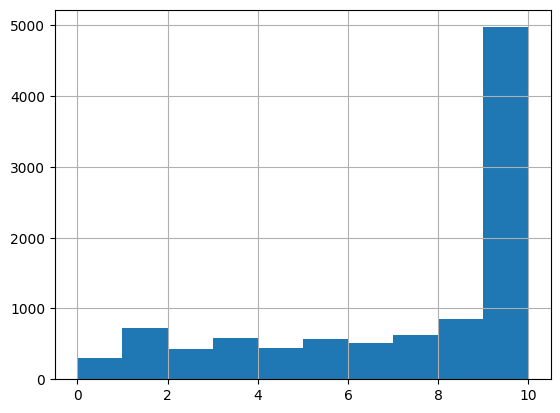

In [119]:
train_emd = pd.read_json("./data/total_text_embs_minilm.json")
test_emd = pd.read_json("./data/text_embs_minilm_test.json")

# train_emd['score'] = train_emd['score'].apply(lambda x: np.clip(int(x - 3*np.random.normal(loc = 1)), 0, 8) if x > 7 else x)
# train_emd['score'] = train_emd['score'].apply(lambda x: 7 if x > 7 else 6)
train_emd['score'].hist()
# train_emd['text_emb'][0]

Trainable params: 560.641K


Train:   0%|          | 0/282 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1: train_loss=9.4530, val_rmse=2.8018


Train:   0%|          | 0/282 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2: train_loss=7.5790, val_rmse=2.6613


Train:   0%|          | 0/282 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3: train_loss=6.7751, val_rmse=2.7327


Train:   0%|          | 0/282 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4: train_loss=6.1367, val_rmse=2.5930


Train:   0%|          | 0/282 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5: train_loss=5.5810, val_rmse=2.5982


Train:   0%|          | 0/282 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6: train_loss=5.0859, val_rmse=2.6338


Train:   0%|          | 0/282 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7: train_loss=4.6733, val_rmse=2.6453


Train:   0%|          | 0/282 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8: train_loss=4.3539, val_rmse=2.5952


Train:   0%|          | 0/282 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9: train_loss=3.9929, val_rmse=2.6185


Train:   0%|          | 0/282 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: train_loss=3.7815, val_rmse=2.6248


Train:   0%|          | 0/282 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: train_loss=3.5955, val_rmse=2.6414


Train:   0%|          | 0/282 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: train_loss=3.3494, val_rmse=2.7227


Train:   0%|          | 0/282 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: train_loss=3.3070, val_rmse=2.5887


Train:   0%|          | 0/282 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: train_loss=3.0769, val_rmse=2.6794


Train:   0%|          | 0/282 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: train_loss=2.9936, val_rmse=2.7267
Best val RMSE: 2.5886501413460206


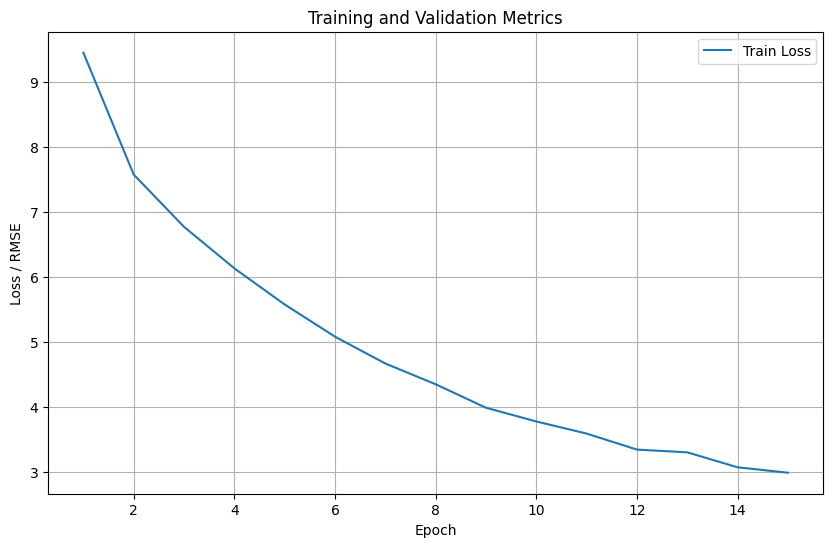

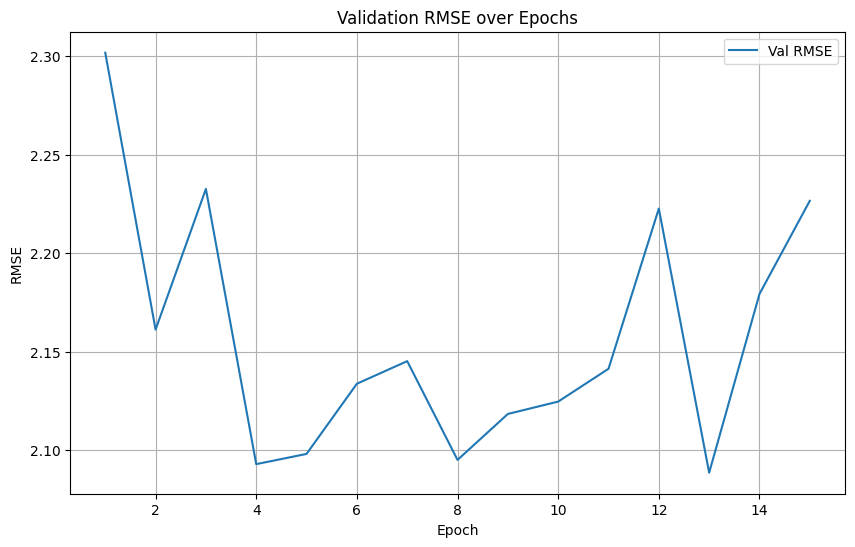

In [124]:
trained_model = run_training_emb(
    train_df = train_emd,
    metric_name_embeddings_map=metric_name_embeddings_map,
    model_choice = 'approach1',
    proj_dim = 256,
    batch_size = 32,
    epochs = 15,
    lr = 2e-4,
    val_frac = 0.1,
    text_batch_size = 32,
    device = DEVICE,
    save_text_embs = True,
    text_emb_save_path = './data/text_embs_bert_multi.json'
)

In [110]:
# ---
# 9) Inference helper (works on df with precomputed text_emb)
# ---
@torch.no_grad()
def predict_emb(model, df: pd.DataFrame, metric_name_embeddings_map: Dict[str, np.ndarray], device: str = DEVICE, batch_size: int = 32):
    # Ensure df has 'text_emb'
    if 'text_emb' not in df.columns:
        print('Precomputing text embeddings for inference...')
        df = precompute_text_embeddings(df, _tokenizer, _frozen_encoder, concat_text, batch_size=32)

    ds = SafetyEmbDataset(df, metric_name_embeddings_map, is_train=False)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
    model.eval()
    preds = []
    for batch in tqdm(loader, desc='Predict'):
        text_emb = batch['text_emb'].to(device)
        metric_emb = batch['metric_emb'].to(device)
        p = model(text_emb, metric_emb)
        preds.append(p.cpu().numpy())
    return np.concatenate(preds)

In [111]:
predictions = predict_emb(
    trained_model,
    test_emd,
    metric_name_embeddings_map,
    batch_size=32,
    device=DEVICE
)

predictions_df = pd.DataFrame({
    'id': test_emd.index+1,
    'score': predictions
})

Predict:   0%|          | 0/114 [00:00<?, ?it/s]

In [43]:
# train_emd['score'].hist()

<Axes: >

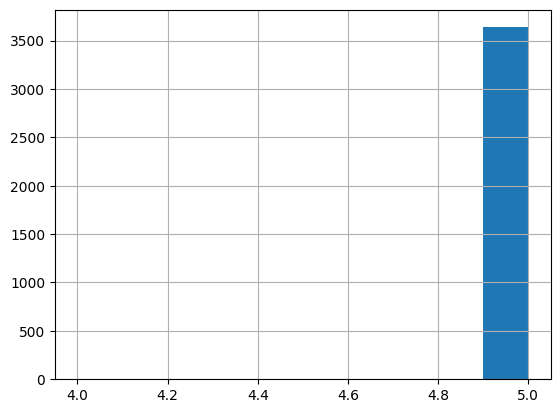

In [112]:
# predictions_df.round().to_csv("./predictions/predictions_24.csv", index=False)
# predictions_df = pd.read_csv("./predictions/submission_6.csv")
# predictions_df['score']  = predictions_df['score'].apply(lambda x: np.clip(x if x >= 6 else x + (1 if np.random.rand() < 0.15 else 0), 0, 10))
predictions_df['score'].round().hist()

In [11]:
# train_data = pd.read_json("./data/augmented_train_20k.json")
# train_data['metric_name'].value_counts()

In [113]:
prediction_2 = pd.read_csv("./predictions/predictions_14.csv")
((prediction_2['score'] - predictions_df['score'].round())**2).mean()

np.float64(11.988455195162176)

### ensembling the models

In [64]:
import json

with open(f"./data/train_data.json", encoding='utf-8') as f:
    train_data = json.load(f)

with open(f"./data/test_data.json", encoding='utf-8') as f:
    test_data = json.load(f)

In [72]:
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

device = "cuda" if torch.cuda.is_available() else "cpu"

def extract_text(record):
    parts = []
    if 'metric_name' in record:
        parts.append(str(record['metric_name']))
    for key in ['prompt', 'input', 'query', 'question']:
        if key in record:
            parts.append(str(record[key]))
            break
    for key in ['system_prompt', 'instruction', 'system']:
        if key in record:
            parts.append(str(record[key]))
            break
    for key in ['expected_response', 'response', 'answer']:
        if key in record:
            parts.append(str(record[key]))
            break
    return " ".join(parts)

train_texts = [extract_text(r) for r in train_data]
train_y = np.array([r.get('score', r.get('target', 0)) for r in train_data])

test_texts = [extract_text(r) for r in test_data]

pseudo_df = pd.read_csv("./data/sample_submission.csv")
pseudo_y = pseudo_df['score'].values

confident = (pseudo_y <= 2) | (pseudo_y >= 8)
conf_idx = np.where(confident)[0]

augment_texts = [test_texts[i] for i in conf_idx]
augment_y = pseudo_y[conf_idx]

combined_texts = train_texts + augment_texts
combined_y = np.concatenate([train_y, augment_y])
combined_y = combined_y.astype(np.float32)

print(f"Original: {len(train_texts)}, Augmented: {len(augment_texts)}")

Original: 5000, Augmented: 1820


In [73]:
embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

combined_emb = embedder.encode(combined_texts, batch_size=64, show_progress_bar=False)
test_emb = embedder.encode(test_texts, batch_size=64, show_progress_bar=False)

X_train, X_val, y_train, y_val = train_test_split(combined_emb, combined_y, test_size=0.2, random_state=7)

class RegNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 768)
        self.bn1 = nn.BatchNorm1d(768)
        self.fc2 = nn.Linear(768, 384)
        self.bn2 = nn.BatchNorm1d(384)
        self.fc3 = nn.Linear(384, 128)
        self.fc4 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.25)
   
    def forward(self, x):
        x = self.drop(self.relu(self.bn1(self.fc1(x))))
        x = self.drop(self.relu(self.bn2(self.fc2(x))))
        x = self.relu(self.fc3(x))
        return self.fc4(x).squeeze()

def train_model(X_tr, y_tr, X_v, y_v, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
   
    X_tr_t = torch.FloatTensor(X_tr).to(device)
    y_tr_t = torch.FloatTensor(y_tr).to(device)
    X_v_t = torch.FloatTensor(X_v).to(device)
   
    net = RegNet(X_tr.shape[1]).to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=0.0008, weight_decay=0.001)
   
    best_score = 999
    no_improve = 0
   
    for epoch in range(60):
        net.train()
        perm = torch.randperm(len(X_tr_t))
       
        for i in range(0, len(X_tr_t), 96):
            batch = perm[i:i+96]
            out = net(X_tr_t[batch])
            loss = nn.MSELoss()(out, y_tr_t[batch])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
       
        net.eval()
        with torch.no_grad():
            val_out = net(X_v_t).cpu().numpy()
            val_rmse = sqrt(mean_squared_error(y_v, val_out))
       
        if val_rmse < best_score:
            best_score = val_rmse
            no_improve = 0
            best_state = net.state_dict().copy()
        else:
            no_improve += 1
            if no_improve >= 8:
                break
   
    net.load_state_dict(best_state)
    return net, best_score

seeds = [17, 88, 201]
models = []
scores = []

for s in tqdm(seeds):
    print(f"Training seed {s}...")
    m, sc = train_model(X_train, y_train, X_val, y_val, s)
    models.append(m)
    scores.append(sc)
    print(f"  Val: {sc:.4f}")

X_test_t = torch.FloatTensor(test_emb).to(device)

predictions = []
for m in models:
    m.eval()
    with torch.no_grad():
        pred = m(X_test_t).cpu().numpy()
        predictions.append(pred)

ensemble_pred = np.mean(predictions, axis=0)

for val in [0, 3, 6, 9]:
    margin = 0.5
    mask = (ensemble_pred >= val-margin) & (ensemble_pred <= val+margin)
    if mask.sum() > 0:
        noise = np.random.normal(0, 0.2, mask.sum())
        ensemble_pred[mask] += noise

ensemble_pred = np.clip(ensemble_pred, 0, 10)
ensemble_pred = np.round(ensemble_pred, 1)

  0%|          | 0/3 [00:00<?, ?it/s]

Training seed 17...
  Val: 2.6278
Training seed 88...
  Val: 2.6577
Training seed 201...
  Val: 2.6669



Final: mean=7.21, std=1.67
Low (0-3): 78
Mid (4-7): 1289
High (8-10): 1350


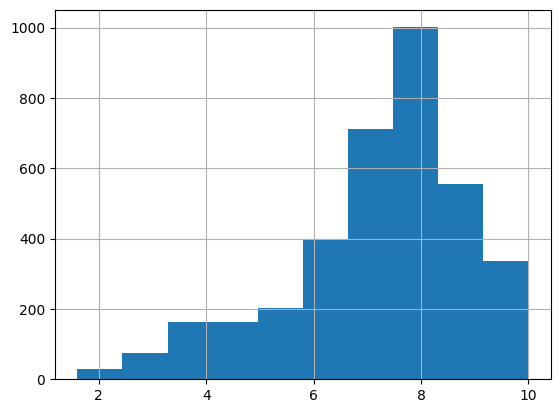

In [75]:
output = pd.DataFrame({
    "ID": np.arange(1, len(ensemble_pred)+1),
    "score": ensemble_pred
})

output.to_csv("./predictions/submission_new.csv", index=False)
output['score'].hist()

print(f"\nFinal: mean={ensemble_pred.mean():.2f}, std={ensemble_pred.std():.2f}")
print(f"Low (0-3): {(ensemble_pred <= 3).sum()}")
print(f"Mid (4-7): {((ensemble_pred > 3) & (ensemble_pred <= 7)).sum()}")
print(f"High (8-10): {(ensemble_pred >= 8).sum()}")